# Ejemplo de ejecución para generar imágenes en tiempo real

## Presión a nivel del mar de GFS y datos de estaciones METAR

En esta notebook de ejemplo se muestra la interacción de distintas fuentes de informacón provistas por Unidata para generar dos figuras como _plantilla_ pero que pueden editarse rápidamente con el conjunto de parámetros que se presentarán a continuación.

Se asume que esta notebook será ejecutada en Google Colab por lo que muchas de las bibliotecas de python ya se encuentran instaladas en la instancia de ejecución de Colab.

- Primero se instalan algunas bibliotecas obligatorias; en este caso `pip` se encarga de resolver las dependencias necesarias.
- Es posible que sea necesario ejetutar esta celda dos veces si aparece algún error.
- Es necesario prestar atención a los mensajes por si hace falta reiniciar el entorno de ejecución; esto no afecta a la ejecución posterior del código.
- En ocasiones es necesario instalar GDAL y Proj a nivel sistema usando `apt-get`.

Luego se detallan los `import` 

In [ ]:
!pip install python-awips
!pip install metpy
!pip install siphon

#!apt-get install -qq libgdal-dev libproj-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import cartopy
print(cartopy.__version__)  # por algunas dependencias es necesario saber la API disponible de Cartopy
import cartopy.crs as ccrs
from shapely.geometry import Polygon
import numpy as np
import scipy.ndimage as ndimage

from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange

from metpy.calc import wind_components
import metpy.calc as mpcalc
from metpy.plots import StationPlot, StationPlotLayout
from metpy.units import units

from siphon.catalog import TDSCatalog
import netCDF4
from netCDF4 import num2date

0.19.0.post1


## Datos de python-awips

En esta primera etapa se presenta a modo de resumen la descarga de observaciones METAR utilizando el servicio EDEX en la nube proporcionado por Unidata.

### METAR

En este caso se descargarán algunos datos METAR disponibles en el servidor EDEX en la nube de Unidata. Se cambia el tipo de dato y se usa un método distinto para obtener la información.

Se agrega además una sección de código que permite definir un rango de búsqueda horaria.

In [2]:
# No hace falta repetirlo si ya fue ejecutado
edex_url = 'edex-cloud.unidata.ucar.edu'
DataAccessLayer.changeEDEXHost(edex_url)

# Configuro el requerimiento al servidor
obs_request = DataAccessLayer.newDataRequest()
obs_request.setDatatype('obs')

# Se arma un Polygon de shapely para agregar al request y pedir un
# recorte de los datos.
# LON-W LON-E LAT-S LAT-N
bbox = [-100, -20, -70, 0]
envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                    (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                    (bbox[0],bbox[2])])
obs_request.setEnvelope(envelope)

# Aca defino una lista de variables a pedir que contenga el METAR
single_value_params = ["timeObs", "stationName", "longitude", "latitude",
                       "temperature", "dewpoint", "windDir", 'altimeter',
                       "windSpeed", "seaLevelPress", 'timeObs']
# En algunos casos se puede obtener información adicional.
#multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]
#pres_weather, sky_cov, sky_layer_base = [],[],[]
params = single_value_params #+ multi_value_params
obs = dict({params: [] for params in params})
obs_request.setParameters(*(params))

print(obs_request)

# Fijo un rango de tiempo para los datos que voy a pedir
lastHourDateTime = datetime.utcnow() - timedelta(hours = 0) # se puede poner 1 si esta muy cerca de la hora en punto
start = lastHourDateTime.strftime('%Y-%m-%d %H')
beginRange = datetime.strptime( start + ":00:00", "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( start + ":59:59", "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)
print(timerange)

obs_response = DataAccessLayer.getGeometryData(obs_request, timerange)



DefaultDataRequest(datatype=obs, identifiers={}, parameters=['timeObs', 'stationName', 'longitude', 'latitude', 'temperature', 'dewpoint', 'windDir', 'altimeter', 'windSpeed', 'seaLevelPress', 'timeObs'], levels=[], locationNames=[], envelope=<dynamicserialize.dstypes.com.vividsolutions.jts.geom.Envelope.Envelope object at 0x7f09b7bc3210>)
(Nov 07 22 01:00:00 , Nov 07 22 01:59:59 )


In [3]:
#La idea acá es completar el diccionario obs con los valores conseguidos
# desde el servidor y quedarnos con un solo valor por estación
station_names = []
for ob in obs_response:
    avail_params = ob.getParameters()
    if ob.getString('stationName') not in station_names:
        station_names.append(ob.getString('stationName'))
        for param in single_value_params:
            if param in avail_params:
                if param == 'timeObs':
                    obs[param].append(datetime.fromtimestamp(ob.getNumber(param)/1000.0))
                else:
                    try:
                        obs[param].append(ob.getNumber(param))
                    except TypeError:
                        obs[param].append(ob.getString(param))
            else:
                obs[param].append(None)

Una vez obtenida la información en un formato relativamente crudo, vamos a usar Metpy para poder graficarla. Para ello debemos convertir el conjunto de datos en otro diccionario y convertir algunas unidades.

In [4]:
# Ahora convierto a obs a otro diccionario que sea fácil de levantar por metpy
data_obs = dict()
data_obs['stid'] = np.array(obs['stationName'])
data_obs['latitude']  = np.array(obs['latitude'])
data_obs['longitude'] = np.array(obs['longitude'])
data_obs['air_temperature'] = np.array(obs['temperature'], dtype=float) * units.degC
data_obs['dew_point_temperature'] = np.array(obs['dewpoint'], dtype=float) * units.degC
data_obs['air_pressure_at_sea_level'] = np.array(obs['seaLevelPress'])
data_obs['altimeter'] = np.array(obs['altimeter']) * 33.86 * units.hectopascal  # inHg a hPa
data_obs['time_obs']: np.array(obs['timeObs'])

direction = np.array(obs['windDir'])
direction[direction == -9999.0] = 'nan'

u, v = wind_components(np.array(obs['windSpeed']) * units('m/s'),
                           direction * units.degree)
data_obs['eastward_wind'], data_obs['northward_wind'] = u, v

En este paso se definen algunas características del ploteo que se va a realizar utilizando Metpy. En este caso es el clásico *ploteo synop* con las barbas de viento, la temperatura y la temperatura del punto de roción y la presión reducida al nivel del mar. Se agregan además algunos elementos necesarios como la unidad en la que está la información y el formato del dato.

In [5]:
# Defino que variables sumo al ploteo synop
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='m/s')
custom_layout.add_value('NW', 'air_temperature', fmt='.0f', units='degC', color='darkred')
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.0f', units='degC', color='darkgreen')
custom_layout.add_value('NE', 'altimeter', fmt='.0f', units='hPa', color='black')

### Siphon y THREDDS

En esta sección se presenta cómo descargar datos desde los catálogos THREDDS disponibilizados por Unidata y la interacción con Siphon. Se dejan como ejemplos algunos de las URL a utilizar en función del dato que se quiere descargar y se insta al usuario a revisar periódicamente los catálogos en búsqueda de más y mejor información, especialmente para Sudamérica.

Se usará como ejemplo el análisis del GFS de 0,25 grados aunque se pueden consultar los pronósticos en otros catálogos.

In [6]:
# https://thredds.ucar.edu/thredds/catalog/catalog.html
# https://thredds.ucar.edu/thredds/idd/forecastModels.html
# https://thredds-test.unidata.ucar.edu/thredds/catalog/idd/forecastModels.html  # ensambles!

# Preparamos aquí la fecha y hora del análisis del modelo que querremos
# utilizar. En otros catálogos es necesario incorporar esta fecha a la URL.
dt = datetime(2022, 11, 6, 12)

base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg_ana/catalog.xml'

#cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
cat = TDSCatalog(base_url)

In [7]:
# En este caso se elige el último análisis disponible, que se puede comprobar
# ejecutando cat.datasets para conseguir el string válido.

ncss = cat.datasets['Latest Collection for GFS Quarter Degree Analysis'].subset()

# Este query es el que usaremos después para pasar los requerimientos de
# fechas y variables a extraer
query = ncss.query()

In [ ]:
# En caso de querer una lista de las variables disponbles en el modelo
# puede ejecutarse la siguiente línea
# ncss.variables

In [8]:
# Se puede acceder a los metadatos de la información requerida. En este caso
# se puede confirmar que el análisis que descargaremos se encuentra dentro
# del rango temporal de datos.
ncss.metadata.time_span

{'begin': '2022-11-04T00:00:00Z', 'end': '2022-11-06T18:00:00Z'}

In [9]:
# Ahora definimos que vamos a conseguir las componentes horizontales del viento
# y la presión reducida a nivel del mar para la fecha y hora detalladas
# anteriormente.

query.time(dt)
query.accept('netcdf')
query.variables('u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric',
                'MSLP_Eta_model_reduction_msl')
query.add_lonlat()

var=MSLP_Eta_model_reduction_msl&var=u-component_of_wind_isobaric&var=v-component_of_wind_isobaric&time=2022-11-06T12%3A00%3A00&accept=netcdf&addLatLon=True

In [10]:
# Finalmente se descargan al disco todos los datos requeridos
# Cuidado, no muestra nada en el mientras tanto y puede demorar varios segundos.
ds = ncss.get_data(query)

In [11]:
# CUIDADO: En algunos ejemplsos puede aparecer que las matrices de latitud y
# longitud tengan nombre 'lat' y 'lon' respectivamente. Es necesario confirmarlo
# mostrando las variables requeridas.
print(list(ds.variables))


['reftime', 'latitude', 'time', 'isobaric', 'longitude', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 'MSLP_Eta_model_reduction_msl', 'LatLon_721X1440-0p13S-180p00E']


In [12]:
# Una vez obtenida la información se procesa para poder ser graficada
# y se convierten a las unidades necesarias.

grid_lon = ds.variables['longitude'][:]
grid_lat = ds.variables['latitude'][:]
xv, yv = np.meshgrid(grid_lon, grid_lat)

times = ds.variables[ds.variables['u-component_of_wind_isobaric'].dimensions[0]]
vtime = num2date(times[:].squeeze(), units=times.units)

# Finalmente para confirmar muestro por pantalla la hora del análisis
print(f'{vtime:%Y-%m-%dT%H:%M:%SZ}')

2022-11-06T12:00:00Z


Ahora se crea la figura requerida: la presión reducida a nivel del mar junto con el *ploteo synop* de METAR. Además se usa Cartopy para descargar límites físicos y políticos.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

Text(0.5, 1.0, 'METAR 2022-11-07 01:00:00\nMSLP 2022-11-06T12:00:00Z')

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


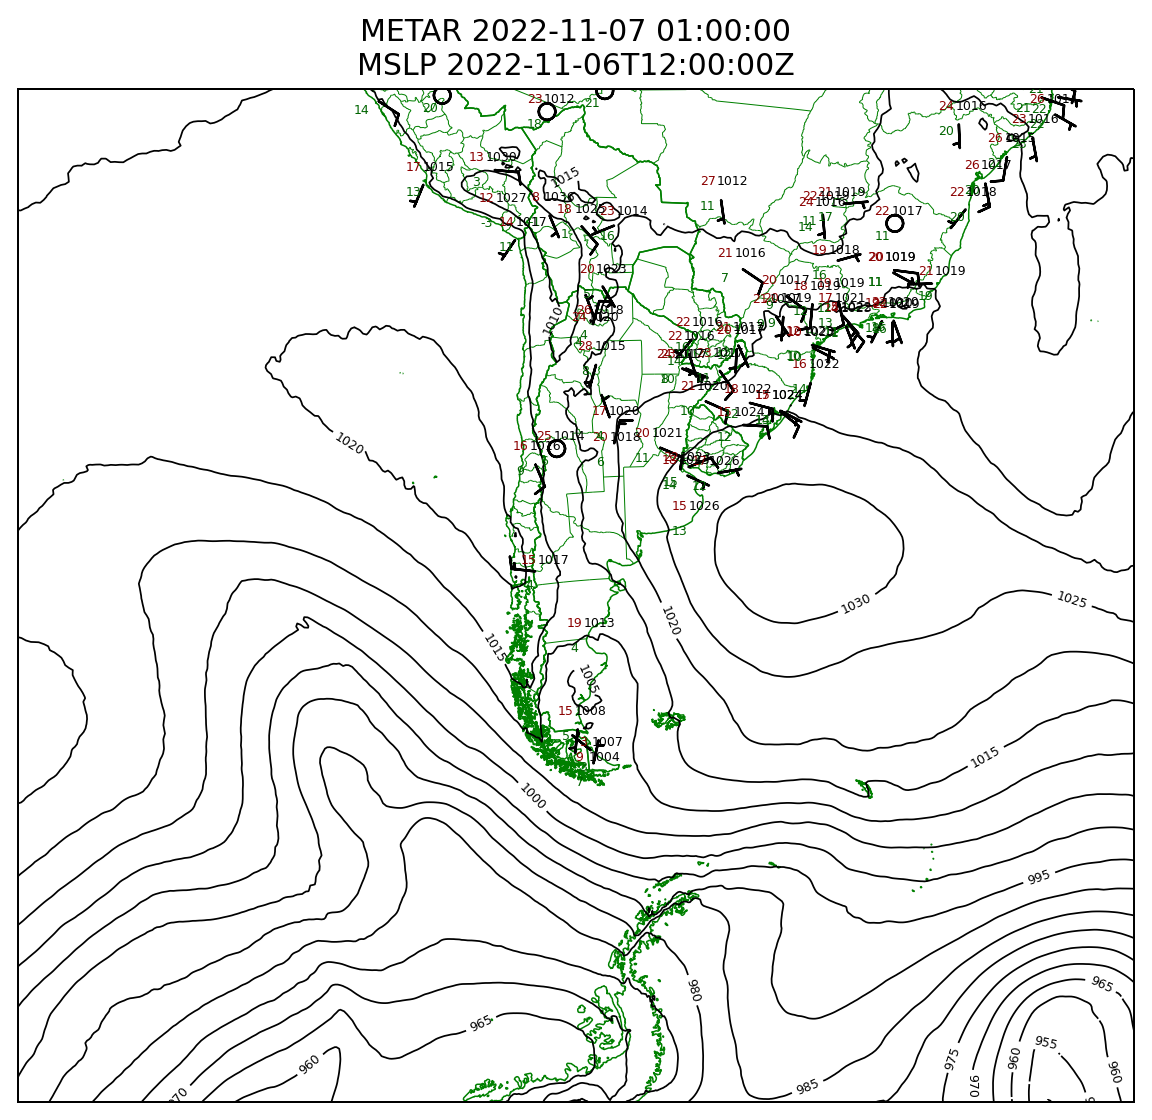

In [13]:
width = 9000.*1000
height = 8000.*1000
extent = [-width*0.55, width*0.4, -height*0.6, height*0.37]
projection = ccrs.Stereographic(central_latitude=-35,
                                central_longitude=-60)

fig, ax = plt.subplots(figsize=(8,8), dpi=180,
                       subplot_kw=dict(projection=projection))
ax.set_extent(extents=extent, crs=projection)

provincias = cartopy.feature.NaturalEarthFeature(category='cultural',
                                                 name='admin_1_states_provinces_lines',
                                                 scale='10m',
                                                 facecolor='none')
   
paises = cartopy.feature.NaturalEarthFeature(category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none')
ax.add_feature(provincias, edgecolor='g', linewidth=0.4, zorder=-1)
ax.add_feature(paises, edgecolor='g', linewidth=0.6, zorder=-2)

cont = ax.contour(xv, yv, ds.variables['MSLP_Eta_model_reduction_msl'][0, :, :]/100,
                  linewidths=0.7, levels=range(950, 1041, 5), colors=('k',),
                  transform=ccrs.PlateCarree())
ax.clabel(cont, fmt='%i', fontsize=5)

# Acá se usa Metpy con las condiciones impuesta para hacer el ploteo de las
# observaciones.
stationplot = StationPlot(ax, data_obs['longitude'], data_obs['latitude'], clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=5)
# con esto se puede agregar el nombre de la estacion a cada dibujo
# stationplot.plot_text((2, 0), data_obs['stid'])
custom_layout.plot(stationplot, data_obs)

ax.set_title(f'METAR {obs["timeObs"][0]}\nMSLP {vtime:%Y-%m-%dT%H:%M:%SZ}')